# Reflexion 开发指南

本指南介绍了如何使用 LangGraph 构建具有自我反思能力的代理，该代理基于 Shinn 等人的 Reflexion 架构。该代理通过自我批判其任务响应，以生成更高质量的最终答案，代价是增加了执行时间。

## 工作流程

1. 安装与设置
2. 设置 LangSmith 用于 LangGraph 开发
3. 定义我们的 LLM
4. Actor（具有反思功能）
5. 构建工具
6. 初始响应器
7. 修订
8. 创建工具节点
9. 构建图形

## 1. 安装与设置

首先，安装 `langgraph`（用于框架）、`langchain_anthropic`（用于 LLM），以及 `tavily-python`（用于搜索引擎）。

In [3]:
%pip install -U --quiet langgraph langchain_anthropic
%pip install -U --quiet tavily-python
import getpass
import os

def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)

_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("OPENAI_API_KEY")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


我们将使用 Tavily Search 作为工具。你可以在 [这里](https://www.tavily.com/) 获取 API 密钥，或者替换为你选择的其他工具。

## 2. 设置 LangSmith 用于 LangGraph 开发

注册 LangSmith 以快速发现问题并提高 LangGraph 项目的性能。LangSmith 允许你使用跟踪数据来调试、测试和监控使用 LangGraph 构建的 LLM 应用程序——阅读更多关于如何开始的信息 [here](https://smith.langchain.com/)。

## 3. 定义我们的 LLM

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4-turbo-preview")

# 你也可以使用其他提供商
# from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(model="claude-3-sonnet-20240229")

## 4. Actor（具有反思功能）

Reflexion 的主要组件是 "actor"，这是一个通过自我批判其响应并根据自我批判重新执行以改进的代理。其主要子组件包括：

- 工具/工具执行
- 初始响应器：生成任务的初始响应（和自我反思）
- 修订者：基于先前的反思重新响应（和反思）

我们首先定义工具执行上下文。

--------------------

## 5. 构建工具

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

## 6. 初始响应器

In [8]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError
# 注意：你必须使用 langchain-core >= 0.3 与 Pydantic v2
from pydantic import BaseModel, Field

class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")

class AnswerQuestion(BaseModel):
    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)} Pay close attention to the function schema."
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

## 7. 修订

In [9]:
revise_instructions = '''Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
'''

扩展初始答案的模式以包含引用。强制模型引用可以鼓励扎实的响应。

In [10]:
# 扩展初始答案的模式以包含引用。
# 强制引用可以鼓励模型生成有根据的响应
class ReviseAnswer(AnswerQuestion):
    references: list[str] = Field(description="Citations motivating your updated answer.")

## 8. 创建工具节点

In [14]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

def run_queries(search_queries: list[str], **kwargs):
    """
    Executes a batch of search queries using the tavily tool.

    Args:
        search_queries (list[str]): A list of search queries to execute.
        kwargs: Additional arguments for the tavily tool.

    Returns:
        Results from the tavily tool as a list of query responses.
    """
    return tavily_tool.batch([{"query": query} for query in search_queries])

tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

## 9. 构建图形

In [19]:
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.tools import StructuredTool

# 定义工具
validate_tool = StructuredTool.from_function(
    lambda x: x,  # 一个占位函数，不执行实际逻辑
    name="validate_tool",  # 工具名称
    description="A tool to validate the schema of AnswerQuestion.",  # 工具描述
)

# 初始化初始响应器
first_responder = ResponderWithRetries(
    runnable=llm,  # 假设您使用了 `ChatOpenAI` 或其他 LLM 实现
    validator=PydanticToolsParser(
        tools=[validate_tool],  # 工具列表，提供一个或多个工具
        pydantic_class=AnswerQuestion,  # 验证响应是否符合 `AnswerQuestion` 模式
    ),
)

In [22]:
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.tools import StructuredTool

# 定义工具
revise_tool = StructuredTool.from_function(
    lambda x: x,  # 一个占位函数
    name="revise_tool",  # 工具名称
    description="A tool to validate the schema of ReviseAnswer.",  # 工具描述
)

# 初始化修订者
revisor = ResponderWithRetries(
    runnable=llm,  # 假设您使用了 `ChatOpenAI` 或其他 LLM 实现
    validator=PydanticToolsParser(
        tools=[revise_tool],  # 工具列表，包含一个或多个工具
        pydantic_class=ReviseAnswer,  # 验证响应是否符合 `ReviseAnswer` 模式
    ),
)

In [23]:
from typing import Literal
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list, add_messages]

MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)

builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
builder.add_edge("draft", "execute_tools")
builder.add_edge("execute_tools", "revise")

def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i

def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

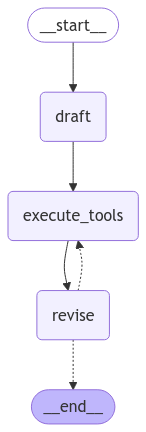

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# 扩展本节课学习的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等。

## 通用任务模式定义
扩展 AnswerQuestion 和 ReviseAnswer，使其支持更通用的生成任务。

In [33]:
from typing import Optional

class GeneralTask(BaseModel):
    task_type: str = Field(
        description="Type of the task, e.g., 'code_generation', 'report_writing', 'general_generation'."
    )
    input: str = Field(description="The input or prompt for the task.")
    output: str = Field(description="The generated content for the task.")
    reflection: Optional[Reflection] = Field(
        default=None,
        description="Reflection on the generated output."
    )
    suggestions: list[str] = Field(
        description="List of suggested improvements for the output based on the reflection."
    )

class ReviseTask(GeneralTask):
    references: list[str] = Field(
        description="References or sources used to support the revised output."
    )


## 工具节点支持通用任务
调整工具节点，使其能够动态支持不同的生成任务。

In [34]:
# 工具节点执行逻辑扩展
def handle_general_task(task_input: GeneralTask, **kwargs):
    """
    Process general tasks, supporting various types such as code generation and report writing.

    Args:
        task_input (GeneralTask): The input task containing type, input, and requirements.
    Returns:
        Updated task output based on processing.
    """
    if task_input.task_type == "code_generation":
        # Example: Invoke a specialized coding API or logic
        task_input.output = f"Generated code for: {task_input.input}"
    elif task_input.task_type == "report_writing":
        # Example: Generate a report using predefined templates or logic
        task_input.output = f"Generated report for: {task_input.input}"
    else:
        task_input.output = f"Generated output for task: {task_input.input}"
    return task_input

# 创建工具节点
general_tool_node = ToolNode(
    [
        StructuredTool.from_function(
            handle_general_task, name="GeneralTaskHandler", description="Handles various general tasks."
        )
    ]
)

## 初始响应器与修订者支持通用任务
调整 first_responder 和 revisor 以支持新的模式。

In [35]:
# 初始响应器
first_responder = ResponderWithRetries(
    runnable=llm,
    validator=PydanticToolsParser(
        tools=[validate_tool],
        pydantic_class=GeneralTask,  # 使用 GeneralTask 验证器
    ),
)

# 修订者
revisor = ResponderWithRetries(
    runnable=llm,
    validator=PydanticToolsParser(
        tools=[revise_tool],
        pydantic_class=ReviseTask,  # 使用 ReviseTask 验证器
    ),
)

## 构建图形
根据任务动态选择工具节点和逻辑。

In [36]:
builder = StateGraph(State)

# 添加节点和边
builder.add_node("draft", first_responder.respond)
builder.add_node("execute_tools", general_tool_node)
builder.add_node("revise", revisor.respond)

builder.add_edge("draft", "execute_tools")
builder.add_edge("execute_tools", "revise")

# 动态调整逻辑
def dynamic_event_loop(state: list):
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

builder.add_conditional_edges("revise", dynamic_event_loop)
builder.add_edge(START, "draft")

# 编译图
graph = builder.compile()

## 可选任务分类器
如果输入未指定任务类型，可以使用分类器来自动确定任务类型。

In [37]:
def classify_task(input_prompt: str) -> str:
    """
    Classify the task based on the input prompt.

    Args:
        input_prompt (str): The task input or prompt.
    Returns:
        str: The classified task type.
    """
    if "write code" in input_prompt.lower():
        return "code_generation"
    elif "write a report" in input_prompt.lower():
        return "report_writing"
    else:
        return "general_generation"

将分类器集成到响应器中：

In [38]:
def preprocess_input(input_prompt: str):
    task_type = classify_task(input_prompt)
    return GeneralTask(task_type=task_type, input=input_prompt, output="", reflection=None, suggestions=[])

## 测试代理

In [43]:
# 输入示例
task_input = GeneralTask(
    task_type="code_generation", 
    input="Write a Python function to calculate factorial.", 
    output="", 
    reflection=None, 
    suggestions=[]
)

# 执行工具节点
result = handle_general_task(task_input)

# 检查结果
print(result.output)

Generated code for: Write a Python function to calculate factorial.


In [42]:
# 自动分类并生成任务
prompt = "Write a detailed report on climate change effects."
classified_task = preprocess_input(prompt)

# 执行任务
result = handle_general_task(classified_task)

# 输出结果
print(result.output)

Generated output for task: Write a detailed report on climate change effects.
